Initial Data:
   step                                              state    move  score
0     0  [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...    drop    829
1     1  [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, ...   right     90
2     2  [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...  rotate    216
3     3  [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...    drop    946
4     4  [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...   right    929

Processed Data:
   step    move  score  0  1  2  3  4  5  6  ...  190  191  192  193  194  \
0     0    drop    829  0  1  0  0  1  1  0  ...    0    1    1    1    0   
1     1   right     90  1  0  1  0  0  0  1  ...    1    0    0    0    0   
2     2  rotate    216  1  0  0  1  1  1  1  ...    0    0    1    0    0   
3     3    drop    946  0  1  0  0  0  0  1  ...    0    1    1    0    0   
4     4   right    929  1  1  0  1  0  0  0  ...    1    1    1    0    1   

   195  196  197  198  199  
0    1    1    1    1    0  
1   

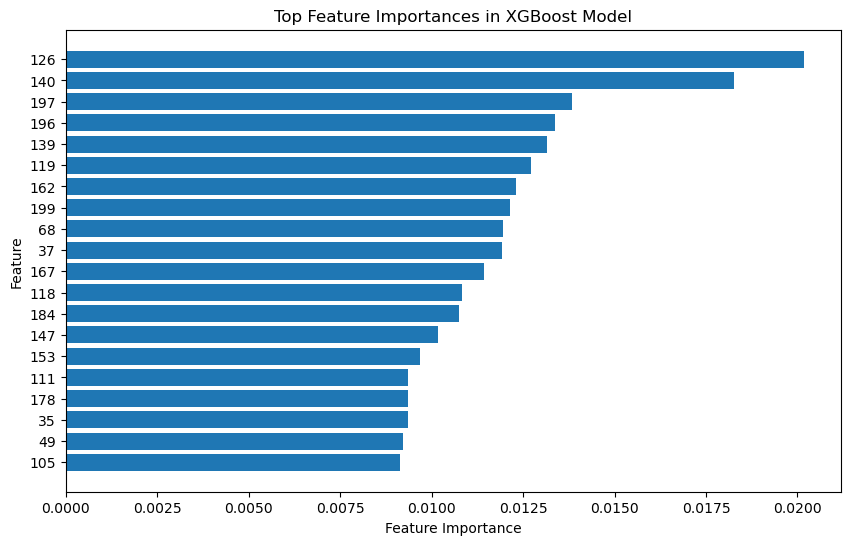

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
file_path = 'tetris_data.csv'  # Replace with your local path
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to understand its structure
print("Initial Data:")
print(data.head())

# Convert the 'state' column from string representation to a list of integers
data['state'] = data['state'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

# Flatten the 'state' column into separate columns
state_df = pd.DataFrame(data['state'].tolist(), index=data.index)
data = data.drop(columns=['state']).join(state_df)

# Display the processed DataFrame
print("\nProcessed Data:")
print(data.head())

# Ensure all column names are strings
data.columns = data.columns.astype(str)

# Split the data into features and labels
features = data.drop(columns=['score'])
labels = data['score']

# Define the preprocessor with one-hot encoding for the 'move' column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list(features.columns)[2:]),  # Scale numerical features
        ('cat', OneHotEncoder(), ['move'])  # One-hot encode the 'move' column
    ],
    remainder='passthrough'
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Apply the preprocessor to the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Initialize the model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_transformed, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -np.mean(cv_scores)

# Predict on the test set
y_pred = best_model.predict(X_test_transformed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nCross-Validation Mean Squared Error: {cv_mse}")
print(f"Test Mean Squared Error: {mse}")
print(f"Test R^2 Score: {r2}")

# Display feature importances
feature_importances = best_model.feature_importances_

# Debug: Print feature importances and their length
print("\nFeature Importances:")
print(feature_importances)
print(f"Length of feature importances: {len(feature_importances)}")

# Get the feature names from the preprocessor
num_features = list(features.columns[2:])
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['move'])
all_features = np.concatenate((cat_features, num_features))

# Debug: Print feature names and their length
print("\nFeature Names:")
print(all_features)
print(f"Length of feature names: {len(all_features)}")

# Ensure the length of feature importances and feature names match
if len(feature_importances) != len(all_features):
    print(f"Mismatch in lengths: {len(feature_importances)} importances, {len(all_features)} features")
    # Adjust the lengths to match
    min_length = min(len(feature_importances), len(all_features))
    feature_importances = feature_importances[:min_length]
    all_features = all_features[:min_length]

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [all_features[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Select top N features to display
top_n = 20
sorted_features = sorted_features[:top_n]
sorted_importances = sorted_importances[:top_n]

# Debug: Print sorted features and importances
print("\nSorted Features and Importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top Feature Importances in XGBoost Model")
plt.gca().invert_yaxis()
plt.show()